In [1]:
pip install face_recognition

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100.1/100.1 MB 10.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for face-recognition-models: filename=face_recognition_models-0.3.0-py2.py3-none-any.whl size=100566185 sha256=6d076944faa7f08f9978431f584b11b77d13119a42ba4d4e6ae5802eb70475c2
  Stored in directory: /root/.cache/pip/wheels/22/a8/60/4a2aeb763d63f50190f4c4e07069a22245347eeafdb3a67551
Successfully built face-recognition-models


In [2]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import os
import cv2

# use seaborn plotting defaults
import seaborn as sns; sns.set()

from tqdm import tqdm

from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA, KernelPCA
from sklearn.pipeline import make_pipeline
from skimage.feature import hog
from skimage import data, exposure


import random
import albumentations as A

from albumentations import (
    HorizontalFlip, IAAPerspective, ShiftScaleRotate, CLAHE, RandomRotate90,
    Transpose, ShiftScaleRotate, Blur, OpticalDistortion, GridDistortion, HueSaturationValue,
    IAAAdditiveGaussianNoise, GaussNoise, MotionBlur, MedianBlur, IAAPiecewiseAffine,
    IAASharpen, IAAEmboss, RandomBrightnessContrast, Flip, OneOf, Compose
)

import dlib
import argparse

import PIL.Image
import PIL.ImageDraw
# import face_recognition as fr

from collections import Counter

In [3]:
import glob
from google.colab import drive
drive.mount('/gdrive', force_remount=True)

Mounted at /gdrive


In [4]:
def found_face(img, crop=True):
    face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_alt2.xml')
    face = face_cascade.detectMultiScale(img, 
                                         minSize=(2, 2), 
                                         maxSize=(64, 64), 
                                         scaleFactor=1.01,
                                         minNeighbors=2,
                                         flags=cv2.CASCADE_SCALE_IMAGE)
    if crop:
        if len(face) > 0:
            for (a, b, w, h) in face:
                face = img[b:b + h, a:a + w]
            h, w = face.shape
            size = min(h, w)
            h0 = int((h - size) / 2)
            w0 = int((w - size) / 2)
        
            face = face[h0: h0 + size, w0: w0 + size]
            face = cv2.resize(face, (64, 64), interpolation = cv2.INTER_AREA)
            return True, face
        return False, img
    return len(face) > 0

In [5]:
def get_aug(image):
    angle = np.arange(-10,11,1)
    angle0 = random.choice(angle)

    shift = 0.01*np.arange(-10,11,1)
    shift0 = random.choice(shift)

    transform = A.Compose([
        A.HorizontalFlip(p=.5),                 
        A.GaussNoise(var_limit=(80, 100), p=.3),
        A.OneOf([
            A.MotionBlur(p=.1),
            A.MedianBlur(blur_limit=3, p=.5),
            A.Blur(blur_limit=3, p=.5)    
        ], p=.3),
        A.OneOf([
            A.CLAHE(clip_limit=2),
            A.IAASharpen(),
            A.IAAEmboss(),
            A.RandomBrightnessContrast(),            
        ], p=.4),
        A.ShiftScaleRotate(shift_limit=0.07,rotate_limit=12,scale_limit=0,p=0.2)
    ])

    return transform(image=image)['image']

In [6]:
Expand = False

x_f, y_f = [], []
x_nf, y_nf = [], []

if Expand:
    dirname = '/gdrive/My Drive/Face recognition/true train'

    names = os.listdir(dirname)

    for label in names:    
        subdir = os.path.join(dirname, label)
        filelist = os.listdir(subdir)
        for fname in tqdm(filelist):
            class_name = int(label)
            img = cv2.imread(os.path.join(subdir, fname), cv2.IMREAD_GRAYSCALE)
            found, face = found_face(img)
            if found:
                x_f.append(face)
                y_f.append(class_name)
            else:
                img = cv2.resize(img, (64, 64), interpolation = cv2.INTER_AREA)
                x_nf.append(img)
                y_nf.append(class_name)
else:
    dirname = '/gdrive/My Drive/Face recognition/train'
    filelist = os.listdir(dirname)
    for fname in tqdm(filelist):
        class_name = int(fname.split('label')[1].split('.jpg')[0])
        img = cv2.imread(os.path.join(dirname, fname), cv2.IMREAD_GRAYSCALE)
        img = cv2.resize(img, (64, 64), interpolation = cv2.INTER_AREA)

        found, face = found_face(img)
        if found:
            x_f.append(face)
            y_f.append(class_name)
        else:
            x_nf.append(img)
            y_nf.append(class_name)

len(x_f), len(x_nf)

100%|██████████| 621/621 [00:36<00:00, 17.02it/s]


(576, 45)

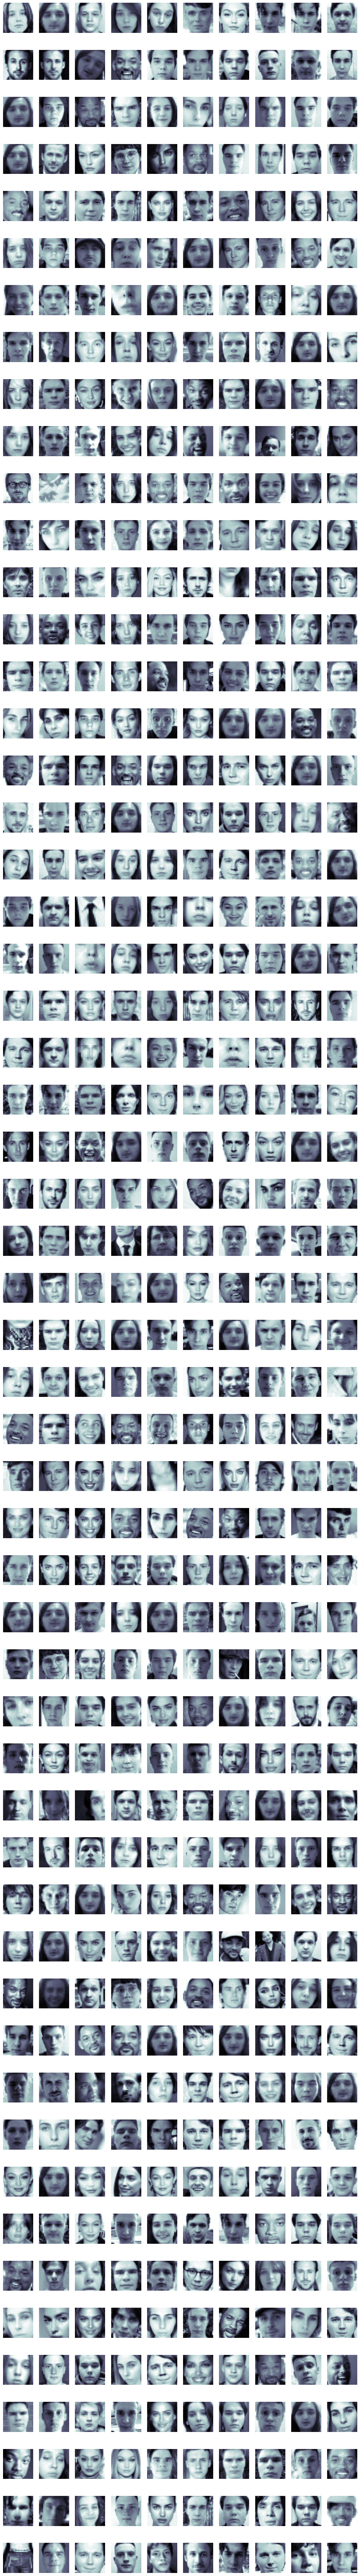

In [7]:
fig, axx = plt.subplots(55, 10, figsize=(15, 110))

for i in range(55):
    for j in range(10):
        axx[i, j].axis('off')
        try:
            axx[i, j].imshow(x_f[i * 10 + j], cmap='bone')
        except:
            pass

In [8]:
xAug_f = []
yAug_f = []
xAug_nf = []
yAug_nf = []

for (a, b) in zip(x_f, y_f):
    for i in range(15):
        try:
            xAug_f.append(get_aug(a))
            yAug_f.append(b)
        except:
            pass


for (a, b) in zip(x_nf, y_nf):
    for i in range(15):
        try:
            xAug_nf.append(get_aug(a))
            yAug_nf.append(b)
        except:
            pass


len(xAug_f), len(xAug_nf)

/usr/local/lib/python3.9/dist-packages/albumentations/imgaug/transforms.py:233: FutureWarning: IAASharpen is deprecated. Please use Sharpen instead
  warnings.warn("IAASharpen is deprecated. Please use Sharpen instead", FutureWarning)
/usr/local/lib/python3.9/dist-packages/albumentations/imgaug/transforms.py:176: FutureWarning: This augmentation is deprecated. Please use Emboss instead
  warnings.warn("This augmentation is deprecated. Please use Emboss instead", FutureWarning)


(8640, 675)

In [9]:
x_hog_f = []
x_hog_nf = []

hog = cv2.HOGDescriptor()

for img in xAug_f:
    before = cv2.resize(img, (64, 128), interpolation = cv2.INTER_AREA)
    after = hog.compute(before)
    x_hog_f.append(after)

for img in xAug_nf:
    before = cv2.resize(img, (64, 128), interpolation = cv2.INTER_AREA)
    after = hog.compute(before)
    x_hog_nf.append(after)


In [10]:
data_f = np.asarray([el.ravel() for el in x_hog_f])
data_nf = np.asarray([el.ravel() for el in x_hog_nf])

In [11]:
random_state = 42
Xtrain_f, Xtest_f, ytrain_f, ytest_f = train_test_split(data_f, yAug_f, stratify = yAug_f, random_state=random_state)
Xtrain_nf, Xtest_nf, ytrain_nf, ytest_nf = train_test_split(data_nf, yAug_nf, stratify = yAug_nf, random_state=random_state)
len(Xtrain_f), len(Xtest_f), len(Xtrain_nf), len(Xtrain_nf) 

(6480, 2160, 506, 506)

In [12]:
model_f = make_pipeline(PCA(200), SVC(kernel = 'rbf', C=150, gamma=0.05, verbose=2))

model_f.fit(Xtrain_f, ytrain_f)

[LibSVM]

Pipeline(steps=[('pca', PCA(n_components=200)),
                ('svc', SVC(C=150, gamma=0.05, verbose=2))])

In [13]:
model_nf = make_pipeline(PCA(150), SVC(kernel = 'rbf', C=150, gamma=0.05, verbose=2))

model_nf.fit(Xtrain_nf, ytrain_nf)

[LibSVM]

Pipeline(steps=[('pca', PCA(n_components=150)),
                ('svc', SVC(C=150, gamma=0.05, verbose=2))])

In [14]:
pred_f = model_f.predict(Xtest_f)
pred_nf = model_nf.predict(Xtest_nf)
print(accuracy_score(ytest_f, pred_f), 
      accuracy_score(ytest_nf, pred_nf),
      sep='\n')

0.9527777777777777
0.9822485207100592


In [15]:
def get_score(C=150, gamma=0.05, verbose=2, pca=150):
    model_f = make_pipeline(PCA(pca), SVC(kernel = 'rbf', C=C, gamma=gamma, verbose=verbose))
    model_f.fit(Xtrain_f, ytrain_f)

    model_nf = make_pipeline(PCA(150), SVC(kernel = 'rbf', C=C, gamma=gamma, verbose=verbose))
    model_nf.fit(Xtrain_nf, ytrain_nf)

    pred_f = model_f.predict(Xtest_f)
    pred_nf = model_nf.predict(Xtest_nf)
    return accuracy_score(ytest_f, pred_f), accuracy_score(ytest_nf, pred_nf)

[LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM]

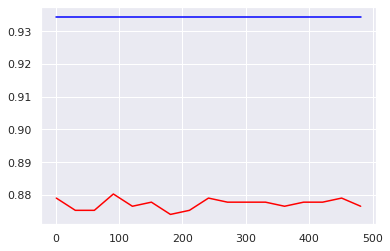

In [ ]:
params = np.arange(1, 500, 30)
scores = [get_score(C=i) for i in params]

plt.plot(params, [x[0] for x in scores], color='red')
plt.plot(params, [x[1] for x in scores], color='blue')

[LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM]

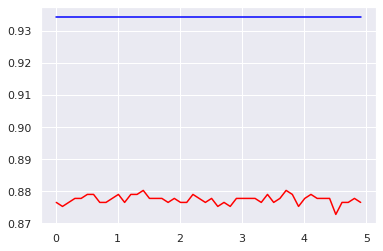

In [ ]:
params = np.arange(0.01, 5, 0.1)
scores = [get_score(C=i) for i in params]

plt.plot(params, [x[0] for x in scores], color='red')
plt.plot(params, [x[1] for x in scores], color='blue')

[LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM]

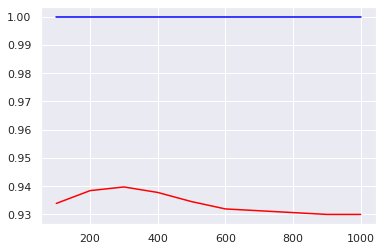

In [ ]:
params = np.arange(100, 1001, 100)
scores = [get_score(pca=i) for i in params]

plt.plot(params, [x[0] for x in scores], color='red')
plt.plot(params, [x[1] for x in scores], color='blue')

In [16]:
model_f = make_pipeline(PCA(300), SVC(kernel = 'rbf', C=150, gamma=0.05, verbose=2))

model_f.fit(data_f, yAug_f)

[LibSVM]

Pipeline(steps=[('pca', PCA(n_components=300)),
                ('svc', SVC(C=150, gamma=0.05, verbose=2))])

In [17]:
model_nf = make_pipeline(PCA(100), SVC(kernel = 'rbf', C=150, gamma=0.05, verbose=2))

model_nf.fit(data_nf, yAug_nf)

[LibSVM]

Pipeline(steps=[('pca', PCA(n_components=100)),
                ('svc', SVC(C=150, gamma=0.05, verbose=2))])

In [18]:
dirname = "/gdrive/My Drive/Face recognition/test"

test_f = []
test_nf = []
names_f = []
names_nf = []

for fname in tqdm(os.listdir(dirname)):
    img = cv2.imread(os.path.join(dirname, fname), cv2.IMREAD_GRAYSCALE)
    id = int(fname.split('img')[1].split('.jpg')[0])
    found, face = found_face(img)
    if found:
        names_f.append(fname)
        test_f.append(face)
    else:
        names_nf.append(fname)
        test_nf.append(img)

len(test_f), len(test_nf)

100%|██████████| 4150/4150 [03:46<00:00, 18.35it/s]


(3840, 310)

In [19]:
hog = cv2.HOGDescriptor()
test_hog_f = []
test_hog_nf = []

for img in test_f:
    before = cv2.resize(img, (64, 128), interpolation = cv2.INTER_AREA)
    after = hog.compute(before)
    test_hog_f.append(after)

for img in test_nf:
    before = cv2.resize(img, (64, 128), interpolation = cv2.INTER_AREA)
    after = hog.compute(before)
    test_hog_nf.append(after)

test_f, test_nf = test_hog_f, test_hog_nf

In [20]:
test_f = np.asarray([el.ravel() for el in test_f])
test_nf = np.asarray([el.ravel() for el in test_nf])

pred_f = model_f.predict(test_f)
pred_nf = model_nf.predict(test_nf)

pred = np.concatenate([pred_f, pred_nf])
names = np.concatenate([names_f, names_nf])

In [21]:
ans = sorted(zip(names, pred), key=lambda fname: int(fname[0].split('img')[1].split('.jpg')[0]))

pred_df = pd.DataFrame(list(ans), columns = ['img', 'label'])
pred_df.head(10)

img  label
0  img0.jpg      7
1  img1.jpg     17
2  img2.jpg     14
3  img3.jpg     13
4  img4.jpg     16
5  img5.jpg      1
6  img6.jpg     10
7  img7.jpg     15
8  img8.jpg      7
9  img9.jpg     13

In [22]:
pred_df.to_csv("submission.csv", index=False)